In [2]:
import joblib
import pandas as pd
import numpy as np

# 选择需要归一化的列
columns_to_normalize_X = ['time_order', 'provincial_load_forecast', 'tie_line_load_forecast',
                        'total_power_forecast', 'new_energy_power_forecast',
                        'hydraulic_power_forecast', 'non_market_power_forecast']
columns_to_normalize_Y = ['dayahead_clearing_price']
# # 加载 scaler
scalerX = joblib.load('./data/scalerX.joblib')
scalerY = joblib.load('./data/scalerY.joblib')
data_train = pd.read_feather('./data/train_data.feather')
data_val = pd.read_feather('./data/val_data.feather')
data_test = pd.read_feather('./data/test_data.feather')

# 对上面的数据集进行归一化
data_train[columns_to_normalize_X] = scalerX.transform(data_train[columns_to_normalize_X])
data_test[columns_to_normalize_X] = scalerX.transform(data_test[columns_to_normalize_X])

data_train[columns_to_normalize_Y] = scalerY.transform(data_train[columns_to_normalize_Y])




In [3]:
trainX = data_train.iloc[:, 1:-1].values  # 前8列作为自变量
trainY = data_train.iloc[:, -1].values # 第9列作为因变量

testX = data_test.iloc[:, 1:-1].values  # 前8列作为自变量
testY = data_test.iloc[:, -1].values # 第9列作为因变量

In [4]:

# 最小二乘
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime
# 创建最小二乘回归模型
model = LinearRegression()

# 拟合模型
model.fit(trainX, trainY)

# 获取模型的截距和系数
intercept = model.intercept_  # XGBoost模型没有截距
coefficients = model.coef_  # XGBoost模型没有系数

print("Intercept:", intercept)
print("Coefficients:", coefficients)  # XGBoost模型没有系数

predY = model.predict(trainX)

# 计算模型的在训练集上的性能指标（例如MAE、RMSE等）

mae = mean_absolute_error(trainY, predY)
rmse = np.sqrt(mean_squared_error(trainY, predY))
print('Train RMSE: {:.4f}, Train MAE: {:.4f}'.format(rmse, mae))

# 使用训练好的模型对测试数据进行预测
predY = model.predict(testX)
predY = scalerY.inverse_transform(predY.reshape(-1, 1)).flatten()
mae = mean_absolute_error(testY, predY)
rmse = np.sqrt(mean_squared_error(testY, predY))
mape = np.mean(np.abs((testY - predY) / testY)) * 100
print('Test RMSE: {:.4f}, Test MAE: {:.4f}, Test MAPE: {:.4f}'.format(rmse, mae, mape))


Intercept: -0.06618283193236879
Coefficients: [ 0.12114226  0.0285131  -0.12565492 -0.18267085 -0.40992191 -0.16969735
  0.0103552 ]
Train RMSE: 0.7732, Train MAE: 0.6376
Test RMSE: 170.7490, Test MAE: 140.7526, Test MAPE: 83.4234


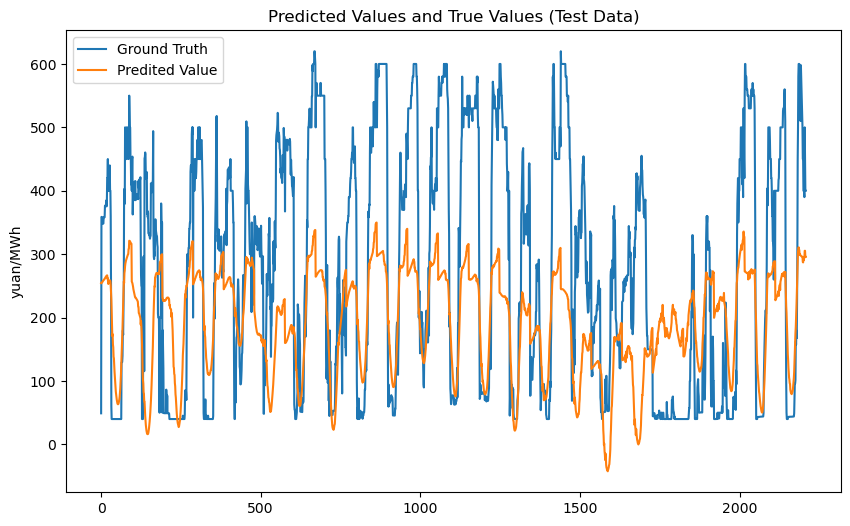

In [5]:
import matplotlib.pyplot as plt

# Plotting the true values against the predicted values for test data
plt.figure(figsize=(10, 6))
plt.plot(testY,label='Ground Truth')
plt.plot(predY,label='Predited Value')
plt.ylabel('yuan/MWh')
plt.title('Predicted Values and True Values (Test Data)')
plt.legend()
plt.show()

Train RMSE: 0.5466, Train MAE: 0.3836
Test RMSE: 151.1290, Test MAE: 117.6509, Test MAPE: 100.2389


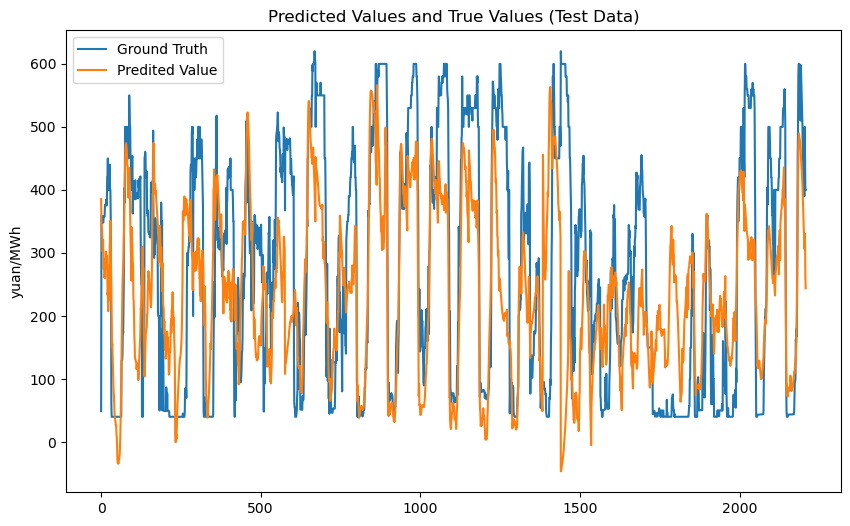

In [7]:
# SVR 回归（支持向量回归）
from sklearn.svm import SVR
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error


model = SVR(C=10)

# 拟合模型
model.fit(trainX, trainY)



# 使用训练好的模型对训练数据进行预测
predY_train = model.predict(trainX)

# 计算模型的在训练集上的性能指标（例如MAE、RMSE等）
mae_train = mean_absolute_error(trainY, predY_train)
rmse_train = np.sqrt(mean_squared_error(trainY, predY_train))
print('Train RMSE: {:.4f}, Train MAE: {:.4f}'.format(rmse_train, mae_train))

# 使用训练好的模型对测试数据进行预测
predY = model.predict(testX)

# 计算模型的在测试集上的性能指标（例如MAE、RMSE等）

predY_test = scalerY.inverse_transform(predY.reshape(-1, 1)).flatten()
mae = mean_absolute_error(testY, predY_test)
rmse = np.sqrt(mean_squared_error(testY, predY_test))
mape = np.mean(np.abs((testY - predY) / testY)) * 100
print('Test RMSE: {:.4f}, Test MAE: {:.4f}, Test MAPE: {:.4f}'.format(rmse, mae, mape))

# Plotting the true values against the predicted values for test data
plt.figure(figsize=(10, 6))
plt.plot(testY,label='Ground Truth')
plt.plot(predY_test,label='Predited Value')
plt.ylabel('yuan/MWh')
plt.title('Predicted Values and True Values (Test Data)')
plt.legend()
plt.show()

Train RMSE: 0.4475, Train MAE: 0.3381
Test RMSE: 143.5724, Test MAE: 112.7088, Test MAPE: 100.3661


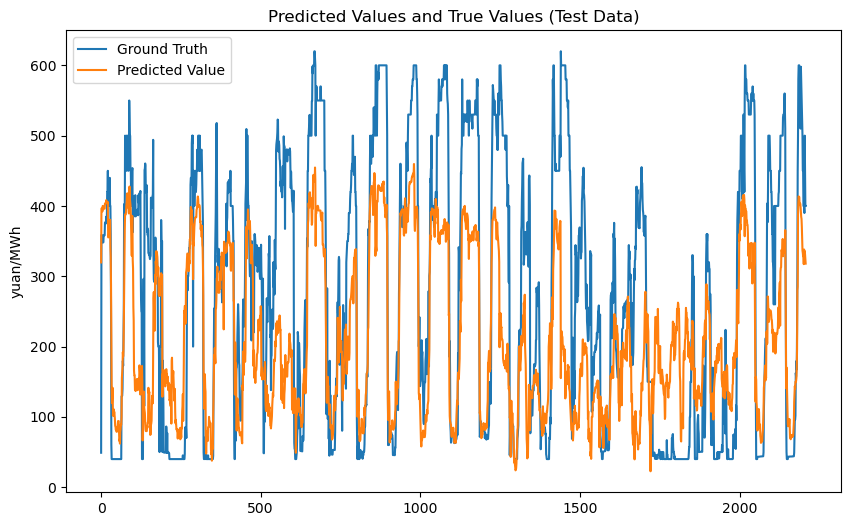

In [8]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 创建 XGBoost 模型
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)

# 拟合模型
model.fit(trainX, trainY)

# 使用训练好的模型对训练数据进行预测
predY_train = model.predict(trainX)

# 计算模型在训练集上的性能指标
mae_train = mean_absolute_error(trainY, predY_train)
rmse_train = np.sqrt(mean_squared_error(trainY, predY_train))
print('Train RMSE: {:.4f}, Train MAE: {:.4f}'.format(rmse_train, mae_train))

# 使用训练好的模型对测试数据进行预测
predY = model.predict(testX)

# 反归一化测试集预测结果
predY_test = scalerY.inverse_transform(predY.reshape(-1, 1)).flatten()

# 计算模型在测试集上的性能指标
mae = mean_absolute_error(testY, predY_test)
rmse = np.sqrt(mean_squared_error(testY, predY_test))
mape = np.mean(np.abs((testY - predY) / testY)) * 100
print('Test RMSE: {:.4f}, Test MAE: {:.4f}, Test MAPE: {:.4f}'.format(rmse, mae, mape))

# 绘制测试数据的真实值与预测值
plt.figure(figsize=(10, 6))
plt.plot(testY, label='Ground Truth')
plt.plot(predY_test, label='Predicted Value')
plt.ylabel('yuan/MWh')
plt.title('Predicted Values and True Values (Test Data)')
plt.legend()
plt.show()


Train RMSE: 0.2547, Train MAE: 0.1786
Test RMSE: 145.5783, Test MAE: 114.6100, Test MAPE: 100.3121


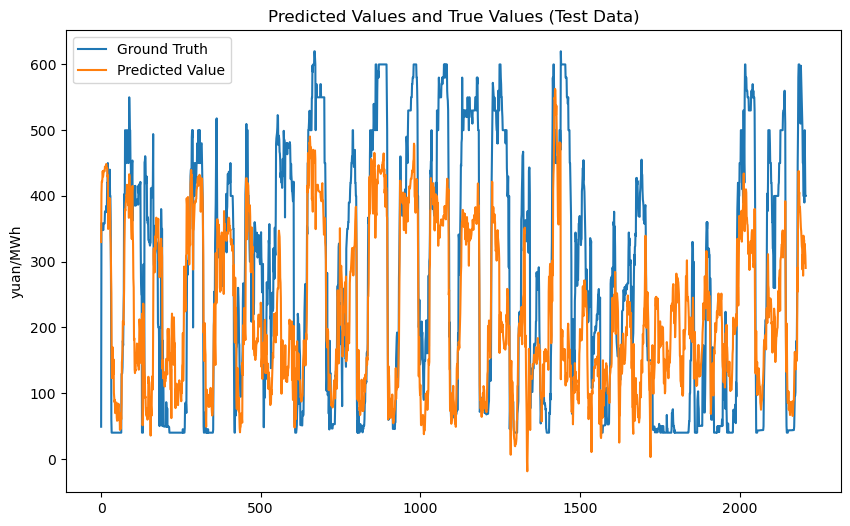

In [9]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 创建 XGBoost 模型
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.1)

# 拟合模型
model.fit(trainX, trainY)

# 使用训练好的模型对训练数据进行预测
predY_train = model.predict(trainX)

# 计算模型在训练集上的性能指标
mae_train = mean_absolute_error(trainY, predY_train)
rmse_train = np.sqrt(mean_squared_error(trainY, predY_train))
print('Train RMSE: {:.4f}, Train MAE: {:.4f}'.format(rmse_train, mae_train))

# 使用训练好的模型对测试数据进行预测
predY = model.predict(testX)

# 反归一化测试集预测结果
predY_test = scalerY.inverse_transform(predY.reshape(-1, 1)).flatten()

# 计算模型在测试集上的性能指标
mae = mean_absolute_error(testY, predY_test)
rmse = np.sqrt(mean_squared_error(testY, predY_test))
mape = np.mean(np.abs((testY - predY) / testY)) * 100
print('Test RMSE: {:.4f}, Test MAE: {:.4f}, Test MAPE: {:.4f}'.format(rmse, mae, mape))

# 绘制测试数据的真实值与预测值
plt.figure(figsize=(10, 6))
plt.plot(testY, label='Ground Truth')
plt.plot(predY_test, label='Predicted Value')
plt.ylabel('yuan/MWh')
plt.title('Predicted Values and True Values (Test Data)')
plt.legend()
plt.show()


In [10]:
import pandas as pd
from sklearn.utils import resample

# 假设data为DataFrame，且包含'price'列
threshold = (400 - scalerY.mean_)/(scalerY.var_)**0.5  # 设置高值阈值
threshold = threshold[0]
high_value_data_train = data_train[data_train['dayahead_clearing_price'] > threshold]
low_value_data_train = data_train[data_train['dayahead_clearing_price'] <= threshold]

# 过采样高值数据，使其样本数接近低值数据
high_value_upsampled = resample(high_value_data_train, 
                                replace=True,   # 允许重复采样
                                n_samples=len(low_value_data_train),  # 使样本数平衡
                                random_state=42)

# 合并数据
data_upsampled = pd.concat([low_value_data_train, high_value_upsampled])


In [14]:
trainX = data_upsampled.iloc[:, 1:-1].values  # 前8列作为自变量
trainY = data_upsampled.iloc[:, -1].values # 第9列作为因变量

In [15]:

# 最小二乘
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime
# 创建最小二乘回归模型
model = LinearRegression()

# 拟合模型
model.fit(trainX, trainY)

# 获取模型的截距和系数
intercept = model.intercept_  # XGBoost模型没有截距
coefficients = model.coef_  # XGBoost模型没有系数

print("Intercept:", intercept)
print("Coefficients:", coefficients)  # XGBoost模型没有系数

predY = model.predict(trainX)

# 计算模型的在训练集上的性能指标（例如MAE、RMSE等）

mae = mean_absolute_error(trainY, predY)
rmse = np.sqrt(mean_squared_error(trainY, predY))
print('Train RMSE: {:.4f}, Train MAE: {:.4f}'.format(rmse, mae))

# 使用训练好的模型对测试数据进行预测
predY = model.predict(testX)
predY = scalerY.inverse_transform(predY.reshape(-1, 1)).flatten()
mae = mean_absolute_error(testY, predY)
rmse = np.sqrt(mean_squared_error(testY, predY))
mape = np.mean(np.abs((testY - predY) / testY)) * 100
print('Test RMSE: {:.4f}, Test MAE: {:.4f}, Test MAPE: {:.4f}'.format(rmse, mae, mape))


Intercept: 0.3101597649851193
Coefficients: [ 0.19771641 -0.06026731 -0.17386036 -0.29670518 -0.43649902 -0.23311874
  0.01978997]
Train RMSE: 0.8023, Train MAE: 0.6023
Test RMSE: 146.9126, Test MAE: 122.9448, Test MAPE: 104.6776


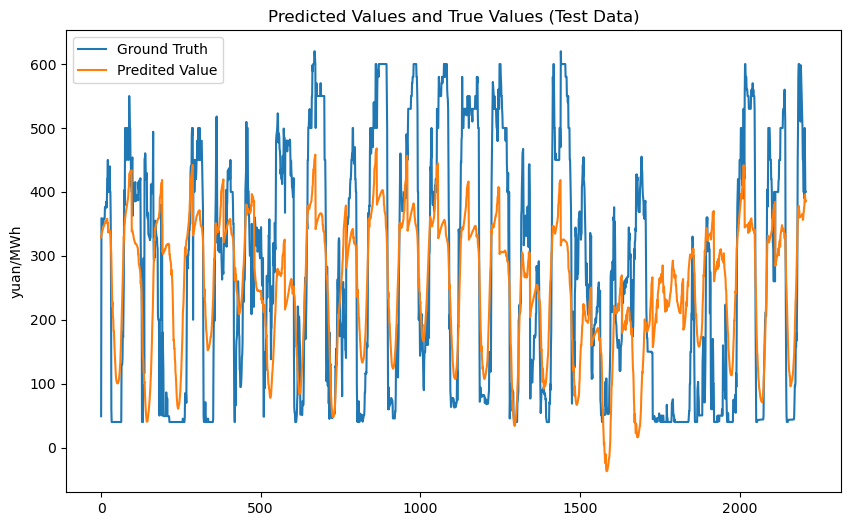

In [16]:
import matplotlib.pyplot as plt

# Plotting the true values against the predicted values for test data
plt.figure(figsize=(10, 6))
plt.plot(testY,label='Ground Truth')
plt.plot(predY,label='Predited Value')
plt.ylabel('yuan/MWh')
plt.title('Predicted Values and True Values (Test Data)')
plt.legend()
plt.show()

Train RMSE: 0.4915, Train MAE: 0.3102
Test RMSE: 180.5056, Test MAE: 134.3695, Test MAPE: 100.2006


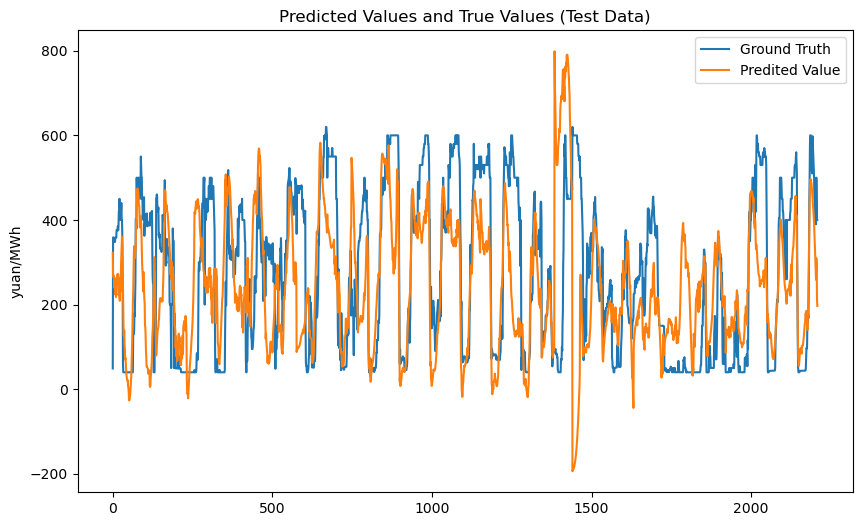

In [17]:
# SVR 回归（支持向量回归）
from sklearn.svm import SVR
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error


model = SVR(C=10)

# 拟合模型
model.fit(trainX, trainY)



# 使用训练好的模型对训练数据进行预测
predY_train = model.predict(trainX)

# 计算模型的在训练集上的性能指标（例如MAE、RMSE等）
mae_train = mean_absolute_error(trainY, predY_train)
rmse_train = np.sqrt(mean_squared_error(trainY, predY_train))
print('Train RMSE: {:.4f}, Train MAE: {:.4f}'.format(rmse_train, mae_train))

# 使用训练好的模型对测试数据进行预测
predY = model.predict(testX)

# 计算模型的在测试集上的性能指标（例如MAE、RMSE等）

predY_test = scalerY.inverse_transform(predY.reshape(-1, 1)).flatten()
mae = mean_absolute_error(testY, predY_test)
rmse = np.sqrt(mean_squared_error(testY, predY_test))
mape = np.mean(np.abs((testY - predY) / testY)) * 100
print('Test RMSE: {:.4f}, Test MAE: {:.4f}, Test MAPE: {:.4f}'.format(rmse, mae, mape))

# Plotting the true values against the predicted values for test data
plt.figure(figsize=(10, 6))
plt.plot(testY,label='Ground Truth')
plt.plot(predY_test,label='Predited Value')
plt.ylabel('yuan/MWh')
plt.title('Predicted Values and True Values (Test Data)')
plt.legend()
plt.show()

Train RMSE: 0.3781, Train MAE: 0.2585
Test RMSE: 136.8732, Test MAE: 105.8678, Test MAPE: 100.3269


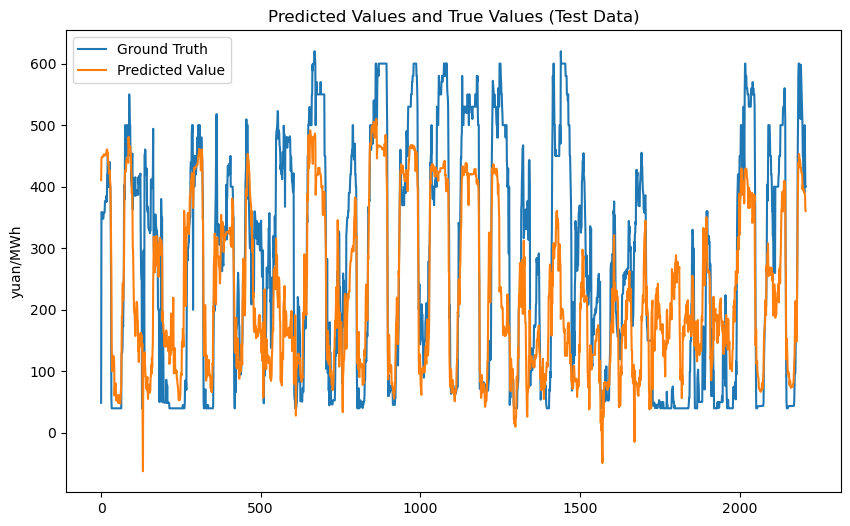

In [32]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 创建 XGBoost 模型
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)

# 拟合模型
model.fit(trainX, trainY)

# 使用训练好的模型对训练数据进行预测
predY_train = model.predict(trainX)

# 计算模型在训练集上的性能指标
mae_train = mean_absolute_error(trainY, predY_train)
rmse_train = np.sqrt(mean_squared_error(trainY, predY_train))
print('Train RMSE: {:.4f}, Train MAE: {:.4f}'.format(rmse_train, mae_train))

# 使用训练好的模型对测试数据进行预测
predY = model.predict(testX)

# 反归一化测试集预测结果
predY_test = scalerY.inverse_transform(predY.reshape(-1, 1)).flatten()

# 计算模型在测试集上的性能指标
mae = mean_absolute_error(testY, predY_test)
rmse = np.sqrt(mean_squared_error(testY, predY_test))
mape = np.mean(np.abs((testY - predY) / testY)) * 100
print('Test RMSE: {:.4f}, Test MAE: {:.4f}, Test MAPE: {:.4f}'.format(rmse, mae, mape))

# 绘制测试数据的真实值与预测值
plt.figure(figsize=(10, 6))
plt.plot(testY, label='Ground Truth')
plt.plot(predY_test, label='Predicted Value')
plt.ylabel('yuan/MWh')
plt.title('Predicted Values and True Values (Test Data)')
plt.legend()
plt.show()


Train RMSE: 0.2155, Train MAE: 0.1318
Test RMSE: 148.8276, Test MAE: 114.0289, Test MAPE: 100.3530


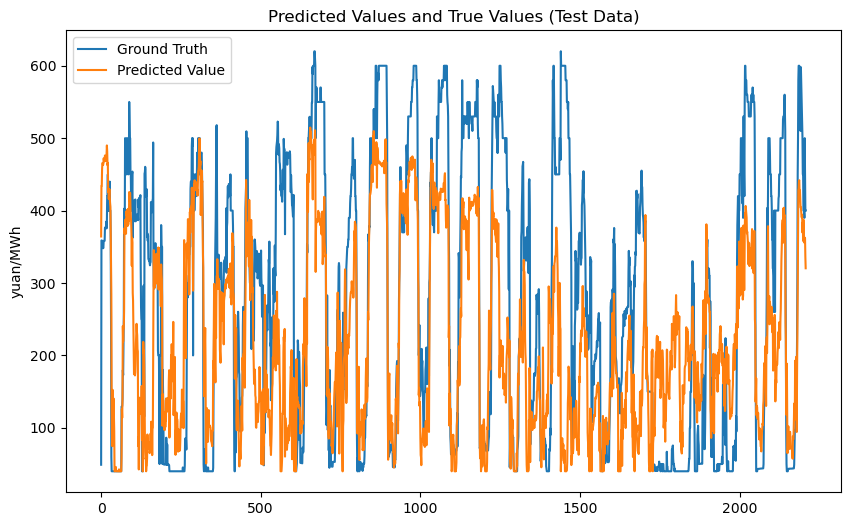

In [20]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 创建 XGBoost 模型
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.1)

# 拟合模型
model.fit(trainX, trainY)

# 使用训练好的模型对训练数据进行预测
predY_train = model.predict(trainX)

# 计算模型在训练集上的性能指标
mae_train = mean_absolute_error(trainY, predY_train)
rmse_train = np.sqrt(mean_squared_error(trainY, predY_train))
print('Train RMSE: {:.4f}, Train MAE: {:.4f}'.format(rmse_train, mae_train))

# 使用训练好的模型对测试数据进行预测
predY = model.predict(testX)

# 反归一化测试集预测结果
predY_test = scalerY.inverse_transform(predY.reshape(-1, 1)).flatten()
predY_test = np.where(predY_test < 40, 40, predY_test)
# 计算模型在测试集上的性能指标
mae = mean_absolute_error(testY, predY_test)
rmse = np.sqrt(mean_squared_error(testY, predY_test))
mape = np.mean(np.abs((testY - predY) / testY)) * 100
print('Test RMSE: {:.4f}, Test MAE: {:.4f}, Test MAPE: {:.4f}'.format(rmse, mae, mape))

# 绘制测试数据的真实值与预测值
plt.figure(figsize=(10, 6))
plt.plot(testY, label='Ground Truth')
plt.plot(predY_test, label='Predicted Value')
plt.ylabel('yuan/MWh')
plt.title('Predicted Values and True Values (Test Data)')
plt.legend()
plt.show()


Train RMSE: 1.0441, Train MAE: 0.7039
Test RMSE: 138.1298, Test MAE: 101.8656, Test MAPE: 100.4242


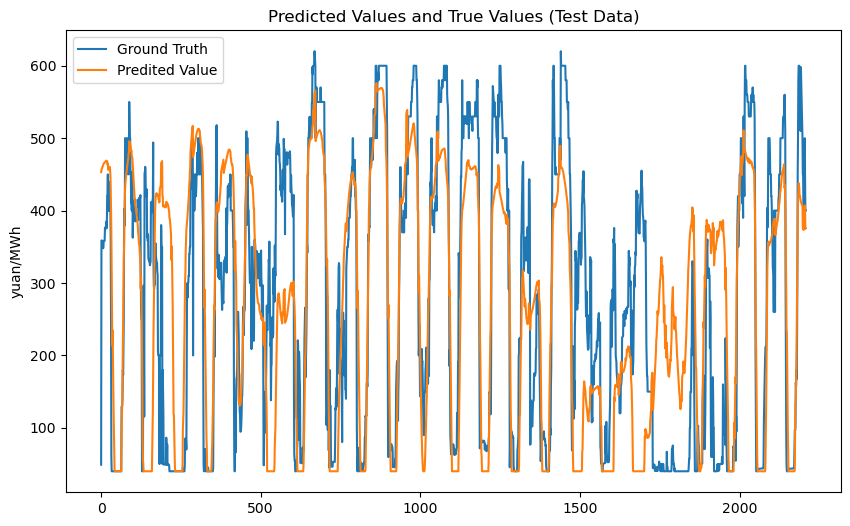

In [21]:
# RANSAC 回归（随机抽样一致性算法）
from sklearn.linear_model import RANSACRegressor
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error


model = RANSACRegressor(max_trials=10000, residual_threshold=0.2)

# 拟合模型
model.fit(trainX, trainY)


# 使用训练好的模型对训练数据进行预测
predY_train = model.predict(trainX)

# 计算模型的在训练集上的性能指标（例如MAE、RMSE等）
mae_train = mean_absolute_error(trainY, predY_train)
rmse_train = np.sqrt(mean_squared_error(trainY, predY_train))
print('Train RMSE: {:.4f}, Train MAE: {:.4f}'.format(rmse_train, mae_train))

# 使用训练好的模型对测试数据进行预测
predY = model.predict(testX)

# 计算模型的在测试集上的性能指标（例如MAE、RMSE等）

predY_test = scalerY.inverse_transform(predY.reshape(-1, 1)).flatten()
predY_test = np.where(predY_test < 40, 40, predY_test)
mae = mean_absolute_error(testY, predY_test)
rmse = np.sqrt(mean_squared_error(testY, predY_test))
mape = np.mean(np.abs((testY - predY) / testY)) * 100
print('Test RMSE: {:.4f}, Test MAE: {:.4f}, Test MAPE: {:.4f}'.format(rmse, mae, mape))

# Plotting the true values against the predicted values for test data
plt.figure(figsize=(10, 6))
plt.plot(testY,label='Ground Truth')
plt.plot(predY_test,label='Predited Value')
plt.ylabel('yuan/MWh')
plt.title('Predicted Values and True Values (Test Data)')
plt.legend()
plt.show()

In [22]:
high_value_data_train.head()

,date,time_order,provincial_load_forecast,tie_line_load_forecast,total_power_forecast,new_energy_power_forecast,hydraulic_power_forecast,non_market_power_forecast,dayahead_clearing_price
36,2024-01-01,-0.414993,-0.552061,0.421501,-0.972274,-0.930065,-1.150302,0.378433,1.215878
163,2024-01-02,0.703684,-0.239566,0.162660,-0.899788,-0.734638,-1.358500,-1.018613,1.464527
164,2024-01-02,0.739770,-0.441053,0.184231,-0.982418,-0.938161,-1.142245,-0.930760,1.530324
165,2024-01-02,0.775857,-0.488954,0.206280,-1.115226,-1.088984,-1.032247,-0.922412,1.859312
166,2024-01-02,0.811943,-0.356657,0.205801,-1.195496,-1.204058,-0.867251,-0.895647,1.865891


# 多对多的预测

In [3]:
trainX = data_train.iloc[:, 1:-1].values  # 前8列作为自变量
trainY = data_train.iloc[:, -1].values # 第9列作为因变量

testX = data_test.iloc[:, 1:-1].values  # 前8列作为自变量
testY = data_test.iloc[:, -1].values # 第9列作为因变量

In [4]:
trainX_ = []
trainY_ = []
for index in range(0,trainX.shape[0],96):
    trainX_.append(trainX[index:index+96].reshape(1,-1))
    trainY_.append(trainY[index:index+96].reshape(1,-1))
trainX_ = np.concatenate(trainX_,axis=0)
trainY_ = np.concatenate(trainY_,axis=0)

In [5]:
testX_ = []
testY_ = []
for index in range(0,testX.shape[0],96):
    testX_.append(testX[index:index+96].reshape(1,-1))
    testY_.append(testY[index:index+96].reshape(1,-1))
testX_ = np.concatenate(testX_,axis=0)
testY_ = np.concatenate(testY_,axis=0)

In [6]:
testX_.shape

(23, 672)

In [7]:
testY_.shape

(23, 96)

In [8]:
trainX_.shape

(244, 672)

In [9]:
trainY_.shape

(244, 96)

In [12]:
# 统计trainY_中超过400的样本个数
threshold = (500 - scalerY.mean_)/(scalerY.var_)**0.5  # 设置高值阈值
threshold = threshold[0]
cout = 0
for i in range(trainY_.shape[0]):
    if sum(trainY_[i]>threshold)>0:
        cout = cout + 1
cout

27

In [44]:

# 最小二乘
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime
# 创建最小二乘回归模型
model = LinearRegression()

# 拟合模型
model.fit(trainX_, trainY_)

# 获取模型的截距和系数
intercept = model.intercept_  # XGBoost模型没有截距
coefficients = model.coef_  # XGBoost模型没有系数

print("Intercept:", intercept)
print("Coefficients:", coefficients)  # XGBoost模型没有系数

predY_ = model.predict(trainX_)

# 计算模型的在训练集上的性能指标（例如MAE、RMSE等）

mae = mean_absolute_error(trainY_, predY_)
rmse = np.sqrt(mean_squared_error(trainY_, predY_))
print('Train RMSE: {:.4f}, Train MAE: {:.4f}'.format(rmse, mae))

# 使用训练好的模型对测试数据进行预测
predY_ = model.predict(testX_)
predY_ = scalerY.inverse_transform(predY_.reshape(-1, 1)).flatten()
mae = mean_absolute_error(testY.reshape(-1, 1), predY)
rmse = np.sqrt(mean_squared_error(testY.reshape(-1, 1), predY))
mape = np.mean(np.abs((testY.reshape(-1, 1) - predY) / testY)) * 100
print('Test RMSE: {:.4f}, Test MAE: {:.4f}, Test MAPE: {:.4f}'.format(rmse, mae, mape))


Intercept: [-2.28908237 -1.69375571 -1.04207987 -0.81531649  0.11225821  0.38100568
  0.60579901  0.67515198  0.48377938 -0.02642793 -0.35002753  0.03820278
 -0.68247903 -0.40314634 -0.05823348 -0.23057456 -1.08083089 -1.3295476
 -0.99429855 -1.52843795 -0.99265216 -1.32225985 -1.13448253 -1.09994722
 -1.29292157 -1.2680721  -1.32176826 -1.61051748 -1.38678994  0.43704986
  0.62324713 -0.5260991   0.79151469  1.45438212  0.77580632  0.64091594
 -1.41166979 -0.23303861 -0.82820864 -2.7313628  -1.33491856 -1.11437597
 -1.65671066 -2.08673717 -3.24287562 -2.4942785  -2.30883967 -2.44129313
 -2.15127431 -1.86178468 -1.5211175  -1.39431852 -1.42494077 -1.40980623
 -1.38026235 -1.87486224 -3.21554192 -3.40277469 -3.61289247 -3.31844699
 -2.06109375 -2.16419292 -2.78989002 -1.91311495 -0.29708263 -0.40076151
 -0.16504392 -0.49671294 -0.52252976 -0.44806941 -1.02917666 -0.93744422
 -0.83073553 -2.1870928  -1.94913232 -1.63329259 -1.17883523 -1.06043729
 -1.01849726 -0.94931558 -0.9263669  -0.1

Train RMSE: 0.0096, Train MAE: 0.0066
Test RMSE: 140.9340, Test MAE: 113.2730, Test MAPE: 99.8507


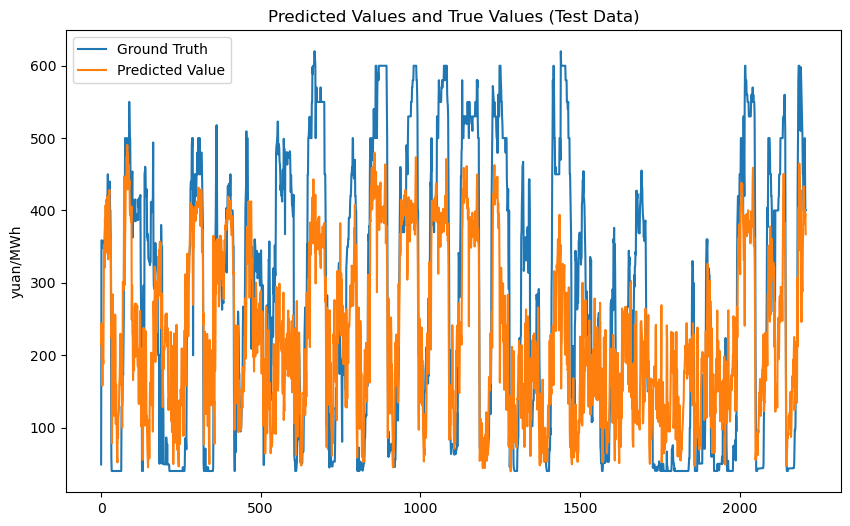

In [47]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 创建 XGBoost 模型
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)

# 拟合模型
model.fit(trainX_, trainY_)

# 使用训练好的模型对训练数据进行预测
predY_train_X_ = model.predict(trainX_)

# 计算模型在训练集上的性能指标
mae_train = mean_absolute_error(trainY_, predY_train_X_)
rmse_train = np.sqrt(mean_squared_error(trainY_, predY_train_X_))
print('Train RMSE: {:.4f}, Train MAE: {:.4f}'.format(rmse_train, mae_train))

# 使用训练好的模型对测试数据进行预测
predY_ = model.predict(testX_)

# 反归一化测试集预测结果
predY_test = scalerY.inverse_transform(predY_.reshape(-1, 1)).flatten()

# 计算模型在测试集上的性能指标
mae = mean_absolute_error(testY.reshape(-1, 1), predY_test)
rmse = np.sqrt(mean_squared_error(testY.reshape(-1, 1), predY_test))
mape = np.mean(np.abs((testY.reshape(-1, 1) - predY) / testY.reshape(-1, 1))) * 100
print('Test RMSE: {:.4f}, Test MAE: {:.4f}, Test MAPE: {:.4f}'.format(rmse, mae, mape))

# 绘制测试数据的真实值与预测值
plt.figure(figsize=(10, 6))
plt.plot(testY.reshape(-1, 1), label='Ground Truth')
plt.plot(predY_test, label='Predicted Value')
plt.ylabel('yuan/MWh')
plt.title('Predicted Values and True Values (Test Data)')
plt.legend()
plt.show()

# 随机划分数据集

In [2]:
from sklearn.model_selection import train_test_split

data_full = pd.read_feather('./data/full_data.feather')
# 将每个分段的数据进行训练和测试集划分
train_X, test_X, train_y, test_y = train_test_split(
    data_full.drop(columns=['date','dayahead_clearing_price']), data_full['dayahead_clearing_price'], test_size=0.01, random_state=42)


# 对上面的数据集进行归一化
train_X.loc[:, columns_to_normalize_X] = scalerX.transform(train_X[columns_to_normalize_X])
test_X.loc[:, columns_to_normalize_X] = scalerX.transform(test_X[columns_to_normalize_X])


train_y = scalerY.transform(train_y.values.reshape(-1, 1))  # reshape 为二维数组


D:\Anaconda\envs\PriceForecast\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Train RMSE: 0.4749, Train MAE: 0.3647
Test RMSE: 70.2100, Test MAE: 52.9060, Test MAPE: 59.6811


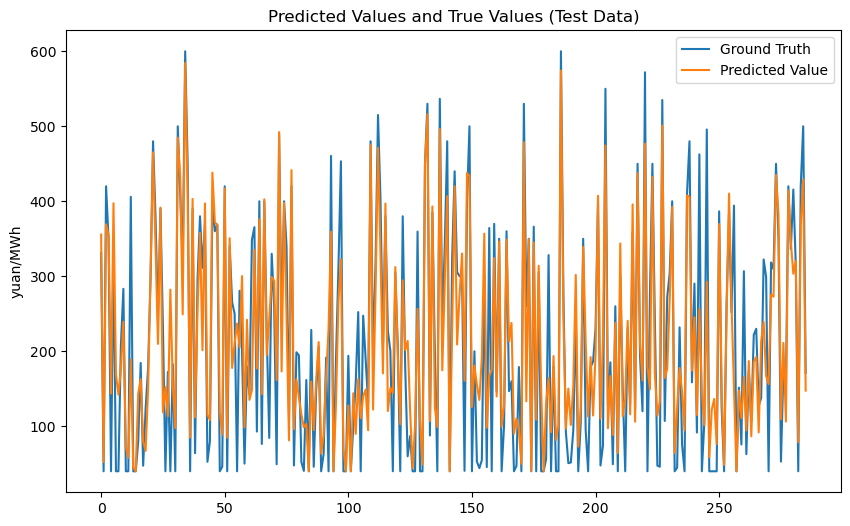

In [3]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 创建 XGBoost 模型
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)

# 拟合模型
model.fit(train_X.values, train_y)

# 使用训练好的模型对训练数据进行预测
predY_train = model.predict(train_X)

# 计算模型在训练集上的性能指标
mae_train = mean_absolute_error(train_y, predY_train)
rmse_train = np.sqrt(mean_squared_error(train_y, predY_train))
print('Train RMSE: {:.4f}, Train MAE: {:.4f}'.format(rmse_train, mae_train))

# 使用训练好的模型对测试数据进行预测
predY = model.predict(test_X.values)

# 反归一化测试集预测结果
predY_test = scalerY.inverse_transform(predY.reshape(-1, 1)).flatten()
predY_test = np.where(predY_test < 40, 40, predY_test)
# 计算模型在测试集上的性能指标
mae = mean_absolute_error(test_y.values, predY_test)
rmse = np.sqrt(mean_squared_error(test_y.values, predY_test))
mape = np.mean(np.abs((test_y.values - predY_test) / test_y.values)) * 100
print('Test RMSE: {:.4f}, Test MAE: {:.4f}, Test MAPE: {:.4f}'.format(rmse, mae, mape))

# 绘制测试数据的真实值与预测值
plt.figure(figsize=(10, 6))
plt.plot(test_y.values, label='Ground Truth')
plt.plot(predY_test, label='Predicted Value')
plt.ylabel('yuan/MWh')
plt.title('Predicted Values and True Values (Test Data)')
plt.legend()
plt.show()


# 分段预测，分四段，每段24个点

In [40]:
trainX = data_train.iloc[:, 1:-1].values  # 前8列作为自变量
trainY = data_train.iloc[:, -1].values # 第9列作为因变量

testX = data_test.iloc[:, 1:-1].values  # 前8列作为自变量
testY = data_test.iloc[:, -1].values # 第9列作为因变量

In [41]:
trainX_ = []
trainY_ = []
for index in range(0,trainX.shape[0],96):
    trainX_.append(trainX[index:index+96].reshape(1,-1))
    trainY_.append(trainY[index:index+96].reshape(1,-1))
trainX_ = np.concatenate(trainX_,axis=0)
trainY_ = np.concatenate(trainY_,axis=0)

In [42]:
testX_ = []
testY_ = []
for index in range(0,testX.shape[0],96):
    testX_.append(testX[index:index+96].reshape(1,-1))
    testY_.append(testY[index:index+96].reshape(1,-1))
testX_ = np.concatenate(testX_,axis=0)
testY_ = np.concatenate(testY_,axis=0)

In [43]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
# Assuming trainX_ has shape (num_sequences, 96, num_features) and trainY_ has shape (num_sequences, 96)
models = []  # To store all 96 models

# Train 96 separate XGBoost models
num_models = 4
model_length = 96//num_models
for i in range(num_models):
    # Target variable for this model
    target = trainY_[:, model_length*i:model_length*i+model_length]
    
    # Initialize the model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=20, max_depth=3)
    
    # Train the model
    model.fit(trainX_.reshape(trainX_.shape[0], -1), target)  # Flatten trainX_ to (num_sequences, 96 * num_features)
    
    # Save the model to the list
    models.append(model)

    # Optional: Evaluate the model's performance on the training data (using MSE or another metric)
    predictions = model.predict(trainX_.reshape(trainX_.shape[0], -1))
    mse = mean_squared_error(target, predictions)
    print(f"Model {i} MSE: {mse}")
    
    # 使用训练好的模型对测试数据进行预测
    predY = model.predict(testX_)

    # 反归一化测试集预测结果
    predY_test = scalerY.inverse_transform(predY.reshape(-1, 1)).flatten()
    predY_test = np.where(predY_test < 40, 40, predY_test)
    # 计算模型在测试集上的性能指标
    mae = mean_absolute_error(testY_[:, model_length*i:model_length*i+model_length].reshape(-1, 1), predY_test)
    rmse = np.sqrt(mean_squared_error(testY_[:, model_length*i:model_length*i+model_length].reshape(-1, 1), predY_test))
    mape = np.mean(np.abs((testY_[:, model_length*i:model_length*i+model_length].reshape(-1, 1) - predY_test) / testY_[:, model_length*i:model_length*i+model_length].reshape(-1, 1)) * 100)
    print('Step{}, Test RMSE: {:.4f}, Test MAE: {:.4f}, Test MAPE: {:.4f}'.format(i, rmse, mae, mape))

Model 0 MSE: 0.059935665504952516
Step0, Test RMSE: 177.3458, Test MAE: 151.4553, Test MAPE: 120.7689
Model 1 MSE: 0.047536110325275015
Step1, Test RMSE: 123.8511, Test MAE: 98.4866, Test MAPE: 148.0799
Model 2 MSE: 0.05279532273916502
Step2, Test RMSE: 124.2755, Test MAE: 97.4616, Test MAPE: 124.0599
Model 3 MSE: 0.050655764158963466
Step3, Test RMSE: 142.8667, Test MAE: 111.8959, Test MAPE: 75.8863


In [26]:
96//3


32